W tym ćwiczeniu dokonasz klasyfikacji obrazów ze zbioru danych **MNIST**. Jest to najbardziej powszechny zbiór danych, używany do klasyfikacji obrazów przy użyciu technologii Uczenia Maszynowego. 

Aby tego dokonać użyjesz biblioteki **Keras**, która w szybki sposób pozwoli zbudować sieć neuronową zdolną do dokonania takiej klasyfikacji z wysoką trafnością. 

Zbiór danych pochodzi ze strony: http://yann.lecun.com/exdb/mnist/. Składa się z dwóch mniejszych podzbiorów:
- treningowego (60000 obrazów czarno-białych o rozmiarze 28x28)
- testowego (10000 obrazów czarno-białych o rozmiarze 28x28)

Popularne zbiory danych używane w celach treningowych, są wbudowane w bibliotekę Keras, dzięki temu nie musimy sciągać danych z zewnątrz! 

Więcej na ten temat dostępne jest pod tym linkiem:

- https://keras.io/datasets/

## Wczytanie danych
Import obiektu ściagającego i wczytującego dane.

In [0]:
# Kontrola losowości - tyle trzeba się namocować aby zmusić Keras do powtarzalnych wyników :)
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras

/Users/kamilkrzyk/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Ściągniecie podzbiorów: treningowy/testowy oraz ich etykiet.

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

## 1.0 Przygotowanie danych

In [0]:
def preprocess_data_mlp(X_train, y_train, X_test, y_test, split_ratio, image_height, image_width):
    # Znormalizuj dane
    X_train_normalized = X_train / 255
    X_test_normalized = X_test / 255
    
    # Rozwiń obrazy do wektora
    X_train_reshaped = X_train_normalized.reshape(-1, image_height * image_width)
    X_test_reshaped = X_test_normalized.reshape(-1, image_height * image_width)
    
    # One-Hot Encoding
    y_train_ohe = keras.utils.to_categorical(y_train, 10)
    y_test_ohe = keras.utils.to_categorical(y_test, 10)
    
    # Podziel dane na zbiory treningowy oraz walidacyjny
    split_index = int(X_train_reshaped.shape[0] * split_ratio)

    X_train_input = X_train_reshaped[:split_index]
    X_val_input = X_train_reshaped[split_index:]

    y_train_input = y_train_ohe[:split_index]
    y_val_input = y_train_ohe[split_index:]
    
    # Zapisz dane w dictionary
    data = {
        "X_train_input": X_train_input,
        "y_train_input": y_train_input,
        "X_val_input": X_val_input,
        "y_val_input": y_val_input,
        "X_test_input": X_test_reshaped,
        "y_test_input": y_test_ohe
    }
    
    return data

In [0]:
data = preprocess_data_mlp(X_train, y_train, X_test, y_test, 0.8, 28, 28)

### 2.0 Budowa i trenowanie sieci neuronowej typu MLP (Multi Layer Perceptron) w Keras

Pora na zbudowanie pierwszej sieci neuronowej. Dokonałem już za Ciebie importów podstawowych obiektów:
- **Sequential** - typ modelu
- **Dense** - podstawowy typ warstwy 
- **Activation** - pozwala na dokonanie aktywacji do uprzednio dodanej warstwy
- **Adam** - optimizer

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

#### Zadanie 1
Stwórz bardzo prostą sieć neuronową.
- wejście: 784 neurony (28x28) 
- warstwa ukryta: 1 neuron
- wyjście: 10 neuronów (ilość klas)

Aby tego dokonać użyj `Sequential` i zapisz w zmiennej `model`. Od tej pory możesz używać funkcji `.add(warstwa/aktywacja`), aby skonstruować swój model. Po każdej wartswie `Dense` powinna znaleźć się operacja `Activation` ustawiona na `relu` dla warstwy ukrytej oraz `softmax` dla warstwy wyjściowej.

In [0]:
model = Sequential()

model.add(Dense(1, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

#### Zadanie 2
Aby sprawdzić co znajduje się w zmiennej model wywołaj na nim `summary()`.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 785       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


#### Zadanie 3
Skompiluj model używając na nim metody `.compile`. Funkcja ta przejmuje następujące parametry:
- **loss** - jest to string z nazwą funkcji, według której będzie obliczany błąd modelu podczas uczenia, użyj stringa *categorical_crossentropy* ponieważ zmagamy się z klasyfikacją typu multiclass (nie binarną)
- **optimizer** - obiekt optimizer, użyj *Adam()*, który dodatkowo przyjmuje opcjonalny parametr *learning_rate*
- **metrics** - lista stringów z nazwami metryk, jakie będą zwracane z procesu trenowania modelu, wstaw jednoelementową listę zawierającą string *accuracy*

`model.compile(parametr1=wartość1, parametr2=wartość2, ...)`

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.01), metrics=["accuracy"])

#### Zadanie 4

Trenowanie modelu. Wywołaj metodę `.fit` na obiekcie `model`. Api jest następujące:
    
    history = model.fit(dane_treningowe, etykiety_treningowe, batch_size=wartość, epochs=wartość,
                        validation_data(dane_walidacyjne, etykiety_walidacyjne))
    
gdzie:
- **batch_size** - fragment danych, podawanych do sieci neuronowej w jednej iteracji treningowej, np. 256 próbek
- **epoka** - jedna epoka mija kiedy do sieci podczas treningu zostanie podane tyle batchy by pokryć cały zbiór (jeżeli mamy 25600 próbek a batch_size to 256 to epoka mija po 100 iteracjach)
- **history** - to słownik, w którym zapisane zostaną zadeklarowane metryki modelu podczas każdej epoki (np. accuracy, error value)

In [0]:
history = model.fit(data["X_train_input"], data["y_train_input"], batch_size=1024, epochs=20,
                    validation_data=(data["X_val_input"], data["y_val_input"]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 0s 8us/step - loss: 2.1159 - acc: 0.1680 - val_loss: 1.9385 - val_acc: 0.2067
Epoch 2/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.8937 - acc: 0.2178 - val_loss: 1.8306 - val_acc: 0.2301
Epoch 3/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.8209 - acc: 0.2429 - val_loss: 1.7762 - val_acc: 0.2439
Epoch 4/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7737 - acc: 0.2579 - val_loss: 1.7382 - val_acc: 0.2579
Epoch 5/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7457 - acc: 0.2664 - val_loss: 1.7159 - val_acc: 0.2746
Epoch 6/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7270 - acc: 0.2782 - val_loss: 1.6960 - val_acc: 0.2794
Epoch 7/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7071 - acc: 0.2920 - val_loss: 1.6713 - val_acc: 0.315

#### Zadanie 5
Kolejnym krokiem jest wyświetlenie finalnych metryk, pokazujących jak model się sprawuje po procesie uczenia.

Aby tego dokonać ma zmiennej `model` wywołaj metodę `.evaluate`. Api jest następujące:

    result = model.evaluate(dane_które_model_ma_sklasyfikować, oczekiwane_wartości)
    
gdzie:
- **result** - to tuple zawierającyc rezultaty dla podanych danych danych

Wykonaj `.evaluate` dla danych treningowych, walidacyjnych oraz testowych, aby wyświetlić metryki dla każdego zbioru.

In [0]:
train_score = model.evaluate(data["X_train_input"], data["y_train_input"], verbose=0)
val_score = model.evaluate(data["X_val_input"], data["y_val_input"], verbose=0)
test_score = model.evaluate(data["X_test_input"], data["y_test_input"], verbose=0)

In [0]:
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 1.570626513560613
 - acc: 0.3647916666666667
Validation data results:
 - error: 1.5593953450520834
 - acc: 0.3729166666666667
Test data results:
 - error: 1.5935951971054076
 - acc: 0.3615


#### Krzywe uczenia
Poniższy kod wykorzystuje zwrócony przez metodę `.fit` obiekt `history` aby wyświetlić zmieniający się błąd modelu w czasie (co epokę).

In [0]:
history.history["loss"]

[2.115869440714518,
 1.8936617364883424,
 1.8209281498591106,
 1.7736912781397502,
 1.7457464551925659,
 1.7269788325627644,
 1.7071185715993245,
 1.6839389298756917,
 1.6709691667556763,
 1.6641610701878866,
 1.653659434636434,
 1.6373355032602945,
 1.6094369846979777,
 1.597635424931844,
 1.590890952428182,
 1.5851089776357015,
 1.58015101591746,
 1.5771352151234945,
 1.5729793659845988,
 1.5728675333658855]

In [0]:
history.history["val_loss"]

[1.9384725116093953,
 1.8305810136795044,
 1.776231468518575,
 1.7381892499923706,
 1.7158518133163452,
 1.6960344924926758,
 1.6712554012934366,
 1.653571993192037,
 1.6465805075963338,
 1.6381106446584066,
 1.6317915045420328,
 1.6049226659138998,
 1.5897816785176595,
 1.5815700565973918,
 1.5729853833516438,
 1.5689729792277018,
 1.563180316289266,
 1.5619564383824667,
 1.560960013071696,
 1.5593952906926474]

In [0]:
import matplotlib.pyplot as plt

# Stworzenie figury
f, ax = plt.subplots()

# Modyfikacja kształtu figury 
f.set_size_inches(10, 6)
    
# Narysowanie krzywej błędu dla danych treningowych (czerwona)
ax.plot(history.history["loss"], c="r")

# Narysowanie krzywej błędu dla danych walidacyjnych (niebieska)
ax.plot(history.history["val_loss"], c="b")

# Opisanie figury
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.set_xticks(range(0, len(history.history["loss"])))
ax.legend(["Training", "Validation"], loc="best");

#### Zadanie 6
Napisz własną funkcję, która zestawia powyższe operacje. Niech funkcja ta przyjmuje nastepujące parametry:
- data - dictionary zawierające dane z funkcji `preprocess_data_mlp`,
- model - stworzony model poprzez wywołanie `Sequential()` wypełniony odpowiednimi warstwami/operacjami Keras,
- opcjonalne parametry do edycji takie jak `learning_rate`, `batch_size` `epochs`.

In [0]:
def run_model(data, model, learning_rate=0.01, batch_size=1024, epochs=20):
    
    # Skompiluj model, podmień parametr optymalizatora z liczby na learning_rate
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
    
    # Trenowanie modelu przy pomocy .fit, zparametryzuj batch_size oraz epochs
    history = model.fit(data["X_train_input"], data["y_train_input"], batch_size=batch_size, epochs=epochs,
                    validation_data=(data["X_val_input"], data["y_val_input"]))
    
    # Ewaluacja modelu dla zbiorów train, val, test 
    train_score = model.evaluate(data["X_train_input"], data["y_train_input"], verbose=0)
    val_score = model.evaluate(data["X_val_input"], data["y_val_input"], verbose=0)
    test_score = model.evaluate(data["X_test_input"], data["y_test_input"], verbose=0)

    # Wyświetlenie metryk
    train_score, train_accuracy = train_score
    print("\nTrain data results:")
    print(" - error: {}".format(train_score))
    print(" - acc: {}".format(train_accuracy))

    val_score, val_accuracy = val_score
    print("Validation data results:")
    print(" - error: {}".format(val_score))
    print(" - acc: {}".format(val_accuracy))

    test_score, test_accuracy = test_score
    print("Test data results:")
    print(" - error: {}".format(test_score))
    print(" - acc: {}".format(test_accuracy))
    
    # Kod wyświetlania krzyw uczenia
    f, ax = plt.subplots()
    f.set_size_inches(10, 6)

    ax.plot(history.history["loss"], c="r")
    ax.plot(history.history["val_loss"], c="b")
    ax.set_title("Error (Categorical Cross-Entropy)")
    ax.set_ylabel("Value")
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(0, len(history.history["loss"])))
    ax.legend(["Training", "Validation"], loc="best");

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 0s 8us/step - loss: 2.0923 - acc: 0.2038 - val_loss: 2.0398 - val_acc: 0.2096
Epoch 2/20
48000/48000 [==============================] - 0s 6us/step - loss: 2.0064 - acc: 0.2163 - val_loss: 1.9971 - val_acc: 0.2205
Epoch 3/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.9483 - acc: 0.2375 - val_loss: 1.8930 - val_acc: 0.2559
Epoch 4/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.8420 - acc: 0.2626 - val_loss: 1.7943 - val_acc: 0.2615
Epoch 5/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7826 - acc: 0.2682 - val_loss: 1.7601 - val_acc: 0.2711
Epoch 6/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7460 - acc: 0.2875 - val_loss: 1.7291 - val_acc: 0.2938
Epoch 7/20
48000/48000 [==============================] - 0s 6us/step - loss: 1.7172 - acc: 0.2908 - val_loss: 1.7038 - val_acc: 0.289

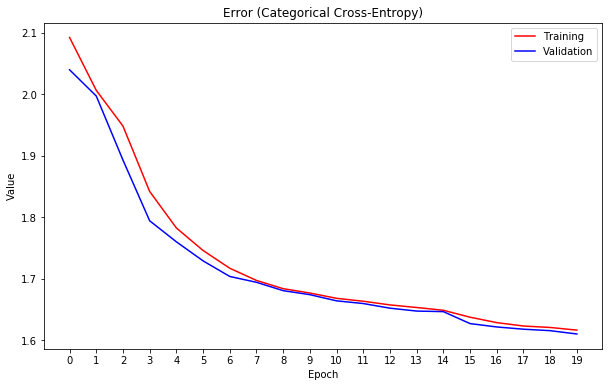

In [0]:
model = Sequential()

model.add(Dense(1, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

run_model(data, model, learning_rate=0.01, batch_size=1024, epochs=20)

### 7.0 Eksperymentowanie z architerkturą
Spróbujmy teraz zobaczyć jak modyfikowanie architektury modelu wpływa na wynik. Sprawdź następujące architektury.

1. Jedna warstwa ukryta z 56 neuronami, aktywacja relu
2. Jedna warstwa ukryta z 128 neuronami, aktywacja relu
3. Jedna warstwa ukryta z 256 neuronami, aktywacja relu
4. Dwie warstwy ukryte odpowiedni z 256(relu)/256(relu) neuronami

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 14us/step - loss: 0.4953 - acc: 0.8505 - val_loss: 0.2449 - val_acc: 0.9319
Epoch 2/20
48000/48000 [==============================] - 1s 11us/step - loss: 0.2170 - acc: 0.9372 - val_loss: 0.1840 - val_acc: 0.9458
Epoch 3/20
48000/48000 [==============================] - 1s 11us/step - loss: 0.1603 - acc: 0.9533 - val_loss: 0.1535 - val_acc: 0.9547
Epoch 4/20
48000/48000 [==============================] - 0s 10us/step - loss: 0.1309 - acc: 0.9623 - val_loss: 0.1407 - val_acc: 0.9578
Epoch 5/20
48000/48000 [==============================] - 0s 10us/step - loss: 0.1095 - acc: 0.9674 - val_loss: 0.1302 - val_acc: 0.9623
Epoch 6/20
48000/48000 [==============================] - 0s 10us/step - loss: 0.0944 - acc: 0.9723 - val_loss: 0.1238 - val_acc: 0.9644
Epoch 7/20
48000/48000 [==============================] - 0s 10us/step - loss: 0.0820 - acc: 0.9752 - val_loss: 0.1176 - val_acc

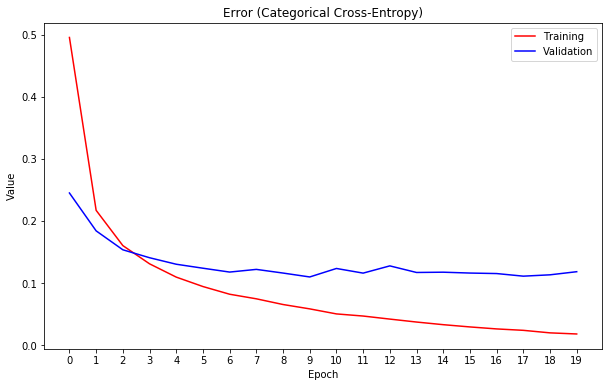

In [0]:
model_1 = Sequential()

model_1.add(Dense(56, input_shape=(784,)))
model_1.add(Activation("relu"))
model_1.add(Dense(10))
model_1.add(Activation("softmax"))

run_model(data, model_1, learning_rate=0.01, batch_size=1024, epochs=20)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.4510 - acc: 0.8628 - val_loss: 0.1949 - val_acc: 0.9426
Epoch 2/20
48000/48000 [==============================] - 1s 15us/step - loss: 0.1658 - acc: 0.9512 - val_loss: 0.1437 - val_acc: 0.9579
Epoch 3/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.1133 - acc: 0.9658 - val_loss: 0.1293 - val_acc: 0.9623
Epoch 4/20
48000/48000 [==============================] - 1s 15us/step - loss: 0.0864 - acc: 0.9740 - val_loss: 0.1122 - val_acc: 0.9673
Epoch 5/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.0637 - acc: 0.9809 - val_loss: 0.0979 - val_acc: 0.9711
Epoch 6/20
48000/48000 [==============================] - 1s 15us/step - loss: 0.0500 - acc: 0.9849 - val_loss: 0.1000 - val_acc: 0.9697
Epoch 7/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.0393 - acc: 0.9885 - val_loss: 0.0973 - val_acc

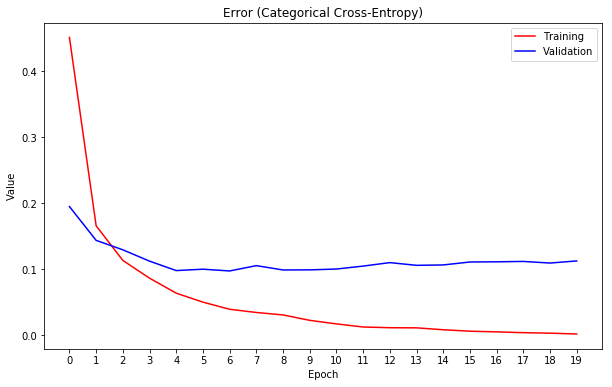

In [0]:
model_2 = Sequential()

model_2.add(Dense(128, input_shape=(784,)))
model_2.add(Activation("relu"))
model_2.add(Dense(10))
model_2.add(Activation("softmax"))

run_model(data, model_2, learning_rate=0.01, batch_size=1024, epochs=20)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 29us/step - loss: 0.4019 - acc: 0.8751 - val_loss: 0.1708 - val_acc: 0.9486
Epoch 2/20
48000/48000 [==============================] - 1s 25us/step - loss: 0.1327 - acc: 0.9601 - val_loss: 0.1183 - val_acc: 0.9652
Epoch 3/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0855 - acc: 0.9741 - val_loss: 0.1014 - val_acc: 0.9697
Epoch 4/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0594 - acc: 0.9826 - val_loss: 0.0949 - val_acc: 0.9708A: 0s - loss: 0.0600 - acc: 
Epoch 5/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0429 - acc: 0.9870 - val_loss: 0.0890 - val_acc: 0.9740
Epoch 6/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0916 - val_acc: 0.9742
Epoch 7/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0252 - acc: 0.9926 

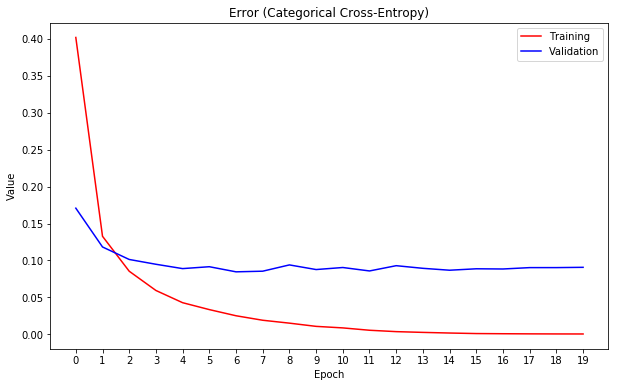

In [0]:
model_3 = Sequential()

model_3.add(Dense(256, input_shape=(784,)))
model_3.add(Activation("relu"))
model_3.add(Dense(10))
model_3.add(Activation("softmax"))

run_model(data, model_3, learning_rate=0.01, batch_size=1024, epochs=20)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 39us/step - loss: 0.4629 - acc: 0.8588 - val_loss: 0.1497 - val_acc: 0.9548
Epoch 2/20
48000/48000 [==============================] - 2s 33us/step - loss: 0.1213 - acc: 0.9615 - val_loss: 0.1144 - val_acc: 0.9648
Epoch 3/20
48000/48000 [==============================] - 2s 33us/step - loss: 0.0778 - acc: 0.9755 - val_loss: 0.1016 - val_acc: 0.9690
Epoch 4/20
48000/48000 [==============================] - ETA: 0s - loss: 0.0596 - acc: 0.981 - 2s 33us/step - loss: 0.0604 - acc: 0.9810 - val_loss: 0.1050 - val_acc: 0.9704
Epoch 5/20
48000/48000 [==============================] - 2s 33us/step - loss: 0.0463 - acc: 0.9848 - val_loss: 0.1147 - val_acc: 0.9675
Epoch 6/20
48000/48000 [==============================] - 2s 33us/step - loss: 0.0366 - acc: 0.9875 - val_loss: 0.1066 - val_acc: 0.9741
Epoch 7/20
48000/48000 [==============================] - 2s 33us/step - loss: 0.0302 - ac

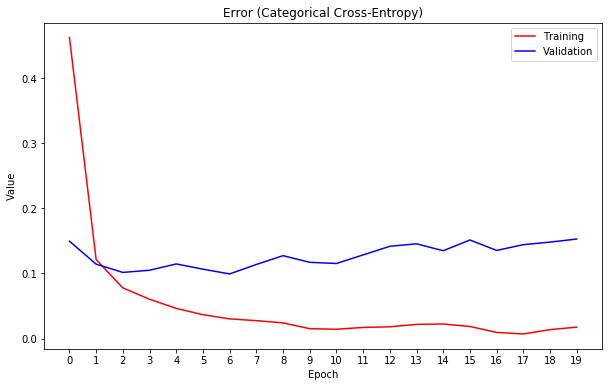

In [0]:
model_4 = Sequential()

model_4.add(Dense(256, input_shape=(784,)))
model_4.add(Activation("relu"))
model_4.add(Dense(256))
model_4.add(Activation("relu"))
model_4.add(Dense(10))
model_4.add(Activation("softmax"))

run_model(data, model_4, learning_rate=0.01, batch_size=1024, epochs=20)

W perceptronie wielowarstwowym wiele warstw nie zawsze działa lepiej. Rzadko kiedy używa się więcej niż trzech warstw ukrytych.

### 8.0 Ostateczny model
Spróbuj zbudować samodzielnie inne **3 inne modele**. Poeksperymentuj z hiperparametrami. Spróbuj pobić wynik najlepszego modelu. 